# Tom Basso’s “Coin-Flip” Experiment — Overview

Tom Basso’s coin-flip experiment showed that an **edge** in a trading system can come from **risk management and exits**, not clever entries. Instead of hunting for a perfect signal, Basso (working with Van K. Tharp in the **1990s**) asked a sharper question: *what happens if entries are random but exits and sizing are disciplined?* Their tests across a diversified basket of futures suggested that combining a **small, fixed risk per trade** (≈1% of equity), **volatility-based trailing stops** (e.g., 3× ATR), and **consistent rules** can yield **positive expectancy** even when the entry is decided by chance.

Equally important, **diversification across relatively uncorrelated markets** was a major contributor to the results. By holding assets whose returns don’t move in lockstep (currencies, rates, energies, metals, grains, livestock), the portfolio benefits when one market draws down while another trends or mean-reverts. Uncorrelated streams:
- **Dampen portfolio volatility**
- **Stabilize compounding** (geometric returns) by avoiding large equity cliffs
- Often **improve risk-adjusted performance**

**In short:** profitability came not from prediction but from **position sizing**, **risk management**, and **cross-market diversification**: sizing kept the system alive through losing streaks, the risk management rules would cut losers while letting winners run, and diversification added uncorrelated returns that tempered drawdowns. This notebook mirrors that setup with a coin-flip bot, **~1% risk per trade**, a **3 × ATR trailing stop**, and a **diversified futures basket**, so you can see the same principles play out in your own results.

## How the experiment was conducted
- **Universe:** 10 liquid futures markets spanning commodities, currencies, rates, and energy (this notebooke only includes 8 though).  
- **Entry:** entirely **random** (flip a coin to choose long/short) for each market.  
- **Always in:** when a position closed, the system stood ready to re-enter on the next bar using the same random entry logic.  
- **Evaluation:** results tracked across all markets to observe the combined equity curve and distribution of wins/losses.

## The rules that mattered (and that we reproduce here)
- **Risk per trade:** ~**1% of equity** (fixed-fractional position sizing).  
- **Volatility measure:** **10-day EMA of ATR** (a smoothed ATR).
- **Initial stop:** **3 × volatility** (i.e., 3 × the 10-day EMA-ATR) from the entry price.
- **Trailing exit:** the **same 3× ATR** stop ratchets with price **only in your favor** (never loosening).
- **Diversification:** apply the identical rules across **multiple, low-correlated futures** to smooth outcomes.

**Why it’s instructive:** the outcome is the classic trend-following profile—**many small losses, a handful of outsized winners**—and, crucially, **compounding** over time when position sizing and exits are kept consistent. This notebook recreates that setup end-to-end with a coin-flip bot, **~1% risk per trade**, and a **3× ATR trailing stop**, run over a representative futures portfolio, with commissions, slippage, ticks, and margins modeled so you can see how systematic exits and sizing turn randomness into results.


**What this notebook does:** It recreates that setup end-to-end with a coin-flip bot, **1% risk per trade**, and a **3× ATR trailing stop**, run over a representative portfolio. We also model **commissions, slippage, ticks, and margins**, and surface clear diagnostics—**per-asset stats, win rate, expectancy, drawdown, and a live equity curve**—so you can see how systematic exits and sizing turn randomness into results.


## Markets used in Basso’s test (10 futures)

- Gold  
- Silver  
- U.S. Bonds (long-term Treasury bond futures)  
- Eurodollars (short-term interest rate futures)  
- Crude Oil  
- Soybeans  
- Sugar  
- Deutsche Mark (pre-euro currency future)  
- British Pound (Pound sterling)  
- Live Cattle  

> **Notes:** The **Deutsche Mark** was later replaced by the **euro**; **Eurodollars** have since largely been superseded by **SOFR** futures in modern markets.

## Mapping to this notebook’s symbols (using 8 of the 10 contracts from Basso's Portfolio)

| Basso market   | Notebook symbol (example) | Comment                         |
|----------------|---------------------------|---------------------------------|
| Gold           | `GC=F`                    | COMEX Gold                      |
| Silver         | `SI=F`                    | COMEX Silver                    |
| U.S. Bonds     | `ZB=F`                    | 30-Year Treasury Bond           |
| Eurodollars    | —                         | Not included here (SOFR analog) |
| Crude Oil      | `CL=F`                    | NYMEX WTI                       |
| Soybeans       | `ZS=F`                    | CBOT Soybeans                   |
| Sugar          | —                         | Not included here               |
| Deutsche Mark  | `6E=F`                    | Euro FX as successor to DEM     |
| British Pound  | `6B=F`                    | British Pound FX                |
| Live Cattle    | `LE=F`                    | CME Live Cattle                 |


## Setup

In [1]:
# jump to repo root (fallback: parent if in notebooks/)
ROOT = !git rev-parse --show-toplevel 2>/dev/null
%cd {ROOT[0] if ROOT else '..'}


/home/dennis/Algo-Trading-Stack


In [2]:
!./setup/fetch_sample_portfolio_futures_data.sh

========== Last 10 years ==========
⏭️  Gold: already exists, skipping.
⏭️  Silver: already exists, skipping.
⏭️  Crude_Oil: already exists, skipping.
⏭️  Soybeans: already exists, skipping.
⏭️  Sugar: already exists, skipping.
⏭️  US_Treasury_Bonds: already exists, skipping.
⏭️  Euro: already exists, skipping.
⏭️  British_Pound: already exists, skipping.
⏭️  Live_Cattle: already exists, skipping.
========== Last 20 years ==========
⏭️  Gold: already exists, skipping.
⏭️  Silver: already exists, skipping.
⏭️  Crude_Oil: already exists, skipping.
⏭️  Soybeans: already exists, skipping.
⏭️  Sugar: already exists, skipping.
⏭️  US_Treasury_Bonds: already exists, skipping.
⏭️  Euro: already exists, skipping.
⏭️  British_Pound: already exists, skipping.
⏭️  Live_Cattle: already exists, skipping.
========== 2000 to 2015 ==========
⏭️  Gold: already exists, skipping.
⏭️  Silver: already exists, skipping.
⏭️  Crude_Oil: already exists, skipping.
⏭️  Soybeans: already exists, skipping.
⏭️  Suga

In [3]:
# Enable autoreload (useful while iterating), and hook Qt into Jupyter
%load_ext autoreload
%autoreload 2
%gui qt


## Project root & imports

Set the project root if your notebook isn't at the repo root. By default, we assume the notebook lives in the root (where `classes/` and `bots/` exist).


In [4]:
import sys, os, pathlib
PROJECT_ROOT = os.path.abspath('.') 
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)
print('PROJECT_ROOT =', PROJECT_ROOT)

os.chdir(PROJECT_ROOT)
print("Current working directory:", os.getcwd())



PROJECT_ROOT = /home/dennis/Algo-Trading-Stack
Current working directory: /home/dennis/Algo-Trading-Stack


In [5]:
from PyQt5 import QtWidgets
import gc

from classes.Backtester_Engine import BacktesterEngine
from classes.Trading_Environment import TradingEnvironment
from classes.ui_main_window import launch_gui

# Bots
from bots.coin_flip_bot.coin_flip_bot import CoinFlipBot

# Exits
from bots.exit_strategies import TrailingATRExit, FixedRatioExit


## Build the exit strategy

In [6]:
exit_strategy = TrailingATRExit(atr_multiple=3.0)

## Build the bot

In [7]:
bot = CoinFlipBot(
    exit_strategy=exit_strategy,
    base_risk_percent=0.01,
    enforce_sessions=False,
    flatten_before_maintenance=True,
    enable_online_learning=False,
    seed=42,
)

## Initialize engine and environment

In [8]:
config_path = "backtest_configs/backtest_config_10_yrs.yaml"

api = BacktesterEngine(config_path=config_path)
api.connect()

env = TradingEnvironment()
env.set_api(api)
env.set_bot(bot)

# Initial indicator compute happens inside TradingEnvironment on connect.
print('Assets:', env.get_asset_list())


Assets: ['6B=F', 'CL=F', '6E=F', 'GC=F', 'LE=F', 'SI=F', 'ZS=F', 'ZB=F']


## Launch GUI and Run Backtest

This starts the backtest control panel and charting UI. You can open charts, start/pause/restart, and view statistics.
If the window doesn't appear from within Jupyter, ensure you ran `%gui qt` above, or run this notebook locally (VS Code, JupyterLab).


In [9]:
launch_gui(env, api)

[FORCED LIQUIDATION] 6B=F: current qty=7, submitting side=sell, qty=7
[FORCED LIQUIDATION] CL=F: current qty=2, submitting side=sell, qty=2
[FORCED LIQUIDATION] 6E=F: current qty=3, submitting side=sell, qty=3
[FORCED LIQUIDATION] LE=F: current qty=3, submitting side=sell, qty=3
[FORCED LIQUIDATION] SI=F: current qty=1, submitting side=sell, qty=1
[FORCED LIQUIDATION] ZS=F: current qty=-5, submitting side=buy, qty=5
[FORCED LIQUIDATION] ZB=F: current qty=-3, submitting side=buy, qty=3


## Backtesting Results

### Show Statistics

In [10]:
# Minimal: pull stats from the running/backtested engine and show them inline

import pandas as pd
from IPython.display import display

stats = api.get_stats_snapshot()   # live snapshot; safe to call anytime

# Portfolio (one row)
display(pd.DataFrame([{
    "Initial Cash":   stats["portfolio"].get("initial_cash", 0.0),
    "Final Equity":   stats["portfolio"].get("total_equity", 0.0),
    "Used Margin":    stats["portfolio"].get("used_margin", 0.0),
    "Max Drawdown %": 100.0 * stats["portfolio"].get("max_drawdown", 0.0),
}]))

# Per-asset table
display(pd.DataFrame.from_dict(stats["per_asset"], orient="index").reset_index().rename(columns={"index":"Symbol"}))


,Initial Cash,Final Equity,Used Margin,Max Drawdown %
0,1000000.0,1.245048e+06,0.0,21.660606


,Symbol,trades,wins,losses,long_trades,short_trades,win_rate,avg_win,avg_loss,profit_factor,expectancy,commission_total,fee_total,max_drawdown
0,6B=F,104,39,65,50,54,0.375000,9099.679486,-5877.788461,0.928888,-261.237981,2196.0,312.0,4.924990e+00
1,CL=F,91,34,57,53,38,0.373626,9423.823530,-4432.280701,1.268247,744.725276,488.0,273.0,1.639998e+15
2,6E=F,97,34,63,49,48,0.350515,9980.882352,-5985.912698,0.899864,-389.304124,1288.0,291.0,3.085518e+01
3,GC=F,121,47,74,61,60,0.388430,10840.851068,-5277.027029,1.304789,983.636364,864.0,363.0,6.877922e+00
4,LE=F,118,40,78,55,63,0.338983,12299.000000,-6518.333334,0.967606,-139.576272,2016.0,354.0,6.331000e+16
5,SI=F,138,63,75,62,76,0.456522,8858.333333,-6055.333335,1.228834,753.079709,1032.0,414.0,1.966030e+00
6,ZS=F,103,29,74,45,58,0.281553,13576.293103,-5778.885136,0.920669,-329.368933,1488.0,309.0,6.396226e+00
7,ZB=F,89,33,56,44,45,0.370787,11487.215909,-5297.712053,1.277769,925.912921,792.0,267.0,2.812500e+14


### Show Equity Curve

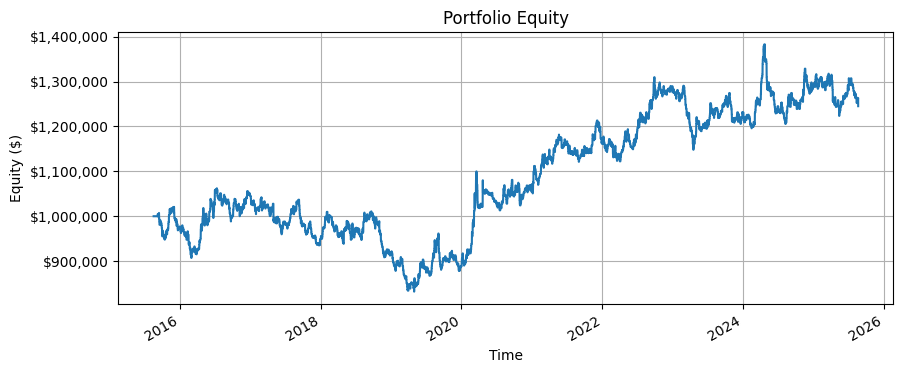

In [11]:
# Assuming `s` is the equity Series you already built
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Times + equity (portfolio). Safe to call anytime; uses the engine's live history.
times, equity = api.get_equity_series()   # None -> portfolio; pass a symbol for per-asset

n = min(len(times), len(equity))
if n == 0:
    print("No equity data available yet.")
else:
    s = pd.Series(equity[:n], index=pd.to_datetime(times[:n])).dropna()

    # (Optional) smooth gaps like weekends/holidays:
    s = s.resample("h").last().ffill()

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(s.index, s.values)
    ax.set_title("Portfolio Equity")
    ax.set_xlabel("Time"); ax.set_ylabel("Equity ($)")
    ax.grid(True)
    
    # Turn off scientific notation/offset and format with commas
    ax.ticklabel_format(axis='y', style='plain', useOffset=False)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'${x:,.0f}'))
    
    fig.autofmt_xdate()
    plt.show()


# But Wait! We can do better!

## Adding Intelligence to the Exit: PPO-Selected Trailing Stops

The first run used a **fixed 3× ATR trailing stop**—faithful to the Basso demo and great for illustrating the importance of risk management. Next, we’ll upgrade the exit with a small dose of machine learning: a **PPO-based policy** that **selects the ATR multiple dynamically** (e.g., choose 1×, 2×, 3×, or 4× ATR) based on recent market context.

### Why this can help
- **Regime-aware stops:** Quiet, mean-reverting markets often benefit from **tighter** stops; volatile/trending regimes often need **looser** stops to avoid whipsaw.  
- **More consistent expectancy:** By adjusting the distance intelligently, the exit aims to **reduce avoidable stop-outs** without choking off winners.  
- **No look-ahead, still disciplined:** The policy only sees **previously closed-bar features**; entries/exits remain rule-based and reproducible.

### How it works here
- **Training data:** We generated offline data by scanning several ATR multiples and recording which one would have performed best at each eligible entry.  
- **Features (prev bar only):** `ATR`, `RSI(14)`, `EMA(21)`, `Close`, and a **position flag** (+1 long / −1 short).  
- **Model:** A PPO classifier maps features → a **discrete ATR multiple** (`{1,2,3,4}` by default).  
- **Execution:** At entry and on each bar while trailing, the policy proposes `K×ATR`. The stop is ratcheted forward **only** when price has moved favorably past entry (never loosens).  
- **Safety:** If a model is missing for a symbol (or SB3 isn’t available), we **fall back to 3× ATR** so the run remains consistent.

### What to expect
- **Similar win rate, improved *profit factor*** in persistent regimes (fewer “too-tight” stop-outs).  
- **Smoother per-asset equity** when trend strength/volatility shifts.  
- **Still Basso-style:** random entries, disciplined exits—now **context-sensitive**.


## Imports

In [12]:
from PyQt5 import QtWidgets
import gc

from classes.Backtester_Engine import BacktesterEngine
from classes.Trading_Environment import TradingEnvironment
from classes.ui_main_window import launch_gui

# Bots
from bots.coin_flip_bot.coin_flip_bot import CoinFlipBot

# Exits
from bots.exit_strategies import TrailingATRExit, FixedRatioExit, RLTrailingATRExit

## Generate ML training data

In [13]:
!PYTHONPATH=. python3 bots/generate_ML_SL_Training_data.py \
  --config bots/configs/ml_sl_config.yaml \
  --output-dir bots/data/yahoo_finance/training_data

Processing 6B=F (yahoo_finance/data/Futures/British_Pound/1Day_timeframe/british_pound_2000-2015.csv)... range [100, 3792)
6B=F: 100%|################################| 3692/3692 [00:24<00:00, 150.60it/s]
Saved to bots/data/yahoo_finance/training_data/rl_stop_loss_training_6B=F.csv
Processing CL=F (yahoo_finance/data/Futures/Crude_Oil/1Day_timeframe/crude_oil_2000-2015.csv)... range [100, 3792)
CL=F: 100%|################################| 3692/3692 [00:28<00:00, 131.85it/s]
Saved to bots/data/yahoo_finance/training_data/rl_stop_loss_training_CL=F.csv
Processing 6E=F (yahoo_finance/data/Futures/Euro/1Day_timeframe/euro_2000-2015.csv)... range [100, 3792)
6E=F: 100%|################################| 3692/3692 [00:34<00:00, 107.71it/s]
Saved to bots/data/yahoo_finance/training_data/rl_stop_loss_training_6E=F.csv
Processing GC=F (yahoo_finance/data/Futures/Gold/1Day_timeframe/gold_2000-2015.csv)... range [100, 3792)
GC=F: 100%|#################################| 3692/3692 [00:37<00:00, 99.41

## Train PPO stop‑loss selector

In [14]:
!PYTHONPATH=. python3 bots/train_ppo_stop_selector.py \
  --input_dir bots/data/yahoo_finance/training_data \
  --output_dir bots/models/PPO_Trailing_Stop_Loss \
  --total_timesteps 300000


[TRAIN] 6B=F — rows: 7326, actions: [1.0, 2.0, 3.0, 4.0], envs: 8
Using cpu device
------------------------------
| time/              |       |
|    fps             | 20991 |
|    iterations      | 1     |
|    time_elapsed    | 0     |
|    total_timesteps | 8192  |
------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 19595       |
|    iterations           | 2           |
|    time_elapsed         | 0           |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.013843633 |
|    clip_fraction        | 0.0984      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.38       |
|    explained_variance   | -0.0171     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0313      |
|    n_updates            | 6           |
|    policy_gradient_loss | -0.0707     |
|    value_loss           |

## Build the PPO RL exit strategy

In [15]:
# ML Trailing Stop Loss Exits
PPO_Models_Dir = "bots/models/PPO_Trailing_Stop_Loss"

# ML Trailing Stop Loss using PPO or LSTM models
exit_strategy = RLTrailingATRExit(
    model_dir=PPO_Models_Dir,
    fallback_multiple=3.0,   # used if a symbol has no model or SB3 isn't available
    ema_span=21,             # use 21 by default; you can sync this to your bot's EMA below
    debug=False,             # set True to print load/inference fallbacks
)

## Build the bot with the new exit strategy

In [16]:
bot = CoinFlipBot(
    exit_strategy=exit_strategy,
    base_risk_percent=0.01,
    enforce_sessions=False,
    flatten_before_maintenance=True,
    enable_online_learning=False,
    seed=42,
)

## Initialize engine and environment

In [17]:
config_path = "backtest_configs/backtest_config_10_yrs.yaml"

api = BacktesterEngine(config_path=config_path)
api.connect()

env = TradingEnvironment()
env.set_api(api)
env.set_bot(bot)

# Initial indicator compute happens inside TradingEnvironment on connect.
print('Assets:', env.get_asset_list())


Assets: ['6B=F', 'CL=F', '6E=F', 'GC=F', 'LE=F', 'SI=F', 'ZS=F', 'ZB=F']


## Launch GUI and Run Backtest

In [18]:
launch_gui(env, api)

[FORCED LIQUIDATION] CL=F: current qty=-22, submitting side=buy, qty=22
[FORCED LIQUIDATION] 6E=F: current qty=33, submitting side=sell, qty=33
[FORCED LIQUIDATION] SI=F: current qty=-14, submitting side=buy, qty=14
[FORCED LIQUIDATION] ZS=F: current qty=55, submitting side=sell, qty=55
[FORCED LIQUIDATION] ZB=F: current qty=-37, submitting side=buy, qty=37


## Backtesting Results

### Show Statistics

In [19]:
# Minimal: pull stats from the running/backtested engine and show them inline

import pandas as pd
from IPython.display import display

stats = api.get_stats_snapshot()   # live snapshot; safe to call anytime

# Portfolio (one row)
display(pd.DataFrame([{
    "Initial Cash":   stats["portfolio"].get("initial_cash", 0.0),
    "Final Equity":   stats["portfolio"].get("total_equity", 0.0),
    "Used Margin":    stats["portfolio"].get("used_margin", 0.0),
    "Max Drawdown %": 100.0 * stats["portfolio"].get("max_drawdown", 0.0),
}]))

# Per-asset table
display(pd.DataFrame.from_dict(stats["per_asset"], orient="index").reset_index().rename(columns={"index":"Symbol"}))


,Initial Cash,Final Equity,Used Margin,Max Drawdown %
0,1000000.0,4.547230e+06,0.0,34.52171


,Symbol,trades,wins,losses,long_trades,short_trades,win_rate,avg_win,avg_loss,profit_factor,expectancy,commission_total,fee_total,max_drawdown
0,6B=F,514,203,311,256,258,0.394942,29654.341133,-15740.233119,1.229738,2187.974222,74928.0,1542.0,3.551710e+00
1,CL=F,501,170,331,252,249,0.339321,34352.882353,-18195.951662,0.969637,-365.009980,23356.0,1503.0,4.919995e+15
2,6E=F,509,184,325,261,248,0.361493,29110.495925,-16057.019231,1.026406,270.726916,47880.0,1527.0,3.067676e+01
3,GC=F,523,196,327,281,242,0.374761,37225.204086,-17359.021407,1.285346,3097.017210,24840.0,1569.0,3.230981e+00
4,LE=F,480,173,307,248,232,0.360417,32814.161850,-17616.091205,1.049686,559.812500,57320.0,1440.0,1.395000e+16
5,SI=F,533,201,332,265,268,0.377111,43731.343284,-20129.668675,1.315268,3953.001876,26788.0,1599.0,3.573250e+00
6,ZS=F,519,190,329,254,265,0.366089,31786.842105,-17809.194529,1.030768,347.350674,51332.0,1557.0,1.966981e+00
7,ZB=F,525,178,347,259,266,0.339048,29250.702247,-18901.161744,0.793850,-2575.386905,37160.0,1575.0,1.125000e+15


### Show Equity Curve

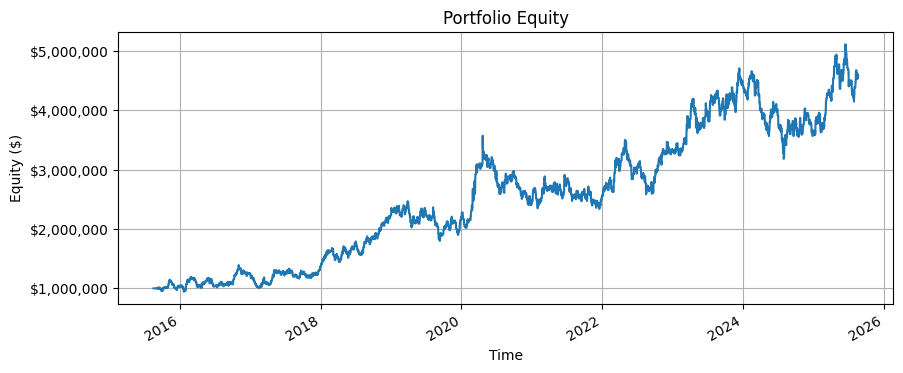

In [20]:
# Assuming `s` is the equity Series you already built
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Times + equity (portfolio). Safe to call anytime; uses the engine's live history.
times, equity = api.get_equity_series()   # None -> portfolio; pass a symbol for per-asset

n = min(len(times), len(equity))
if n == 0:
    print("No equity data available yet.")
else:
    s = pd.Series(equity[:n], index=pd.to_datetime(times[:n])).dropna()

    # (Optional) smooth gaps like weekends/holidays:
    s = s.resample("h").last().ffill()

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(s.index, s.values)
    ax.set_title("Portfolio Equity")
    ax.set_xlabel("Time"); ax.set_ylabel("Equity ($)")
    ax.grid(True)
    
    # Turn off scientific notation/offset and format with commas
    ax.ticklabel_format(axis='y', style='plain', useOffset=False)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'${x:,.0f}'))
    
    fig.autofmt_xdate()
    plt.show()
